# Machine Learning - Exercise 10
# Regularization in ANNs

This exercise illustrates the effects of applying regularization in ANNs.

## Import 

Import libraries that contains the implementations of the functions used in the rest of the program.



In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras as keras

import random
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

# fix random seed
np.random.seed(123)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print("Libraries imported.")

Libraries imported.


## Load data

Load the dataset.

More details on the MNIST dataset are available in http://yann.lecun.com/exdb/mnist/

More details on the Fashion-MNIST dataset are available in https://github.com/zalandoresearch/fashion-mnist 

### Choose the dataset

In [2]:
dataset_name = 'FASHION_MNIST' # 'MNIST' or 'FASHION_MNIST'
if dataset_name == 'MNIST':
  DB = keras.datasets.mnist
else:
  DB = keras.datasets.fashion_mnist


### Load data

Data are normalized in [0,1]

In [3]:
(X_train, y_train), (X_test, y_test) = DB.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0 # Normalization between 0 and 1.

### Summary of the dataset

Print some information about the dataset

In [4]:
print(X_train.shape)
print(y_train.shape)
print("target range: %.0f %.0f" %(np.min(y_train),np.max(y_train)))

ninput = X_train.shape[1]*X_train.shape[2]
nsamples = X_train.shape[0]

class_names = np.unique(y_train)
nclasses = len(class_names)

print("Dataset: %s" %(dataset_name))
print("Number of attributes/features: %d" %(ninput))
print("Number of classes: %d %s" %(len(class_names), str(class_names)))
print("Number of samples: %d" %(nsamples))

(60000, 28, 28)
(60000,)
target range: 0 9
Dataset: FASHION_MNIST
Number of attributes/features: 784
Number of classes: 10 [0 1 2 3 4 5 6 7 8 9]
Number of samples: 60000


### Show an example

Display a random sample.

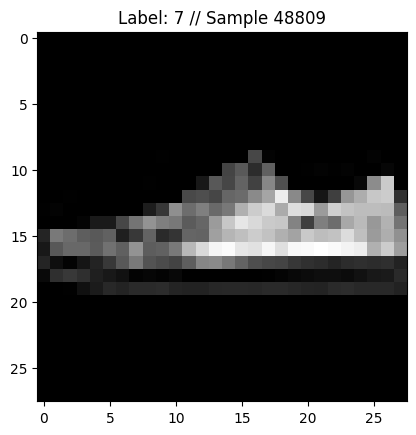

In [5]:
id = random.randrange(0,X_train.shape[0])
plt.imshow(X_train[id],cmap='gray')
plt.title('Label: {} // Sample {}'.format(y_train[id],id))
plt.show()

## Create ANN Models

Model fitting = finding a solution that is stored in the model.

IMPORTANT: solution depends on data split

**1st model** - No regularization (baseline)

In [6]:
models = []
titles = ['Baseline', 'Weight Decay', 'Dropout']

# Without regularization. Simple NN with a 
model_tmp = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)), # We flatten the 28x28 image into a single vector [1, 784]
  keras.layers.Dense(64, activation='relu'), # 784 to 64 with ReLU
  keras.layers.Dense(32, activation='relu'), # 64 to 32 with ReLU
  keras.layers.Dense(len(class_names), activation='softmax') # 32 to 10 with SoftMax (multi-class classification)
])
Wsave = model_tmp.get_weights() # save the initialized weights 
print(model_tmp.summary())
models.append(model_tmp)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


**2nd model** - Weight decay

In [7]:
# Model with regularization
model_tmp = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)), # We flatten the 28x28 image into a single vector [1, 784]
  
  keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)), # from 784 to 64 with ReLU
                                                                                              # Also we add a L2 regularization on layer parameters:
                                                                                              #   - L2 factor (Penalty): 0.001
                                                                                              # These penalties are summed into the loss function that the network optimizes.
                                                                                              # They alter weight propagation through the layers which could facilitate 
                                                                                              # the model to converge optimally -> REDUCES OVERFITTING
  keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
  keras.layers.Dense(len(class_names), activation='softmax')
])
model_tmp.set_weights(Wsave) # use the same initialized weights
print(model_tmp.summary())
models.append(model_tmp)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


**3rd model** - Dropout

In [8]:
# Model with Dropout layer before final Dense Layer
model_tmp = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)),
  keras.layers.Dense(64, activation='relu'),        # | | | | | | | | | | | | (64)
  keras.layers.Dense(32, activation='relu'),        #     | | | | | | | |     (32)
  keras.layers.Dense(16, activation='relu'),        #         | | | |         (16)
  keras.layers.Dense(8, activation='relu'),         #           | |           (8)
  keras.layers.Dropout(0.2),
  keras.layers.Dense(len(class_names), activation='softmax') #   |            (10)
])
Wsave = model_tmp.get_weights() # save the initialized weights 
model_tmp.set_weights(Wsave) # use the same initialized weights
print(model_tmp.summary())
models.append(model_tmp)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 8)                 136       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 10)               

### Define optimizer and compile the models

Note:  
loss `categorical_crossentropy` is used when classes encoded with one_hot representation

loss `sparse_categorical_crossentropy` is used when classes encoded with integer numbers

In [9]:
optimizer = "adam" # choose between adam, adadelta, sgd

if optimizer == "adam":
  pass
elif optimizer == "adadelta":
  pass
elif optimizer == "sgd":
  # in this case set parameters of the optimizer instead of leaving the default ones
  learning_rate = 0.01
  momentum = 1.0
  optimizer = keras.optimizers.SGD(lr = learning_rate, momentum = momentum)

for m in models:
  m.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Fit the model

Using validation data

In [10]:
nepochs = 50
batch_size = 64

histories = []
for i,m in enumerate(models):
  print('Training {} model'.format(titles[i]))
  histories.append(m.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test,y_test)))

Training Baseline model
Epoch 1/50
938/938 [==============================] - 2s 2ms/step - loss: 0.5648 - accuracy: 0.8045 - val_loss: 0.4422 - val_accuracy: 0.8465
Epoch 2/50
938/938 [==============================] - 1s 2ms/step - loss: 0.3966 - accuracy: 0.8600 - val_loss: 0.4136 - val_accuracy: 0.8537
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3550 - accuracy: 0.8725 - val_loss: 0.3793 - val_accuracy: 0.8657
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3290 - accuracy: 0.8815 - val_loss: 0.3691 - val_accuracy: 0.8666
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3119 - accuracy: 0.8862 - val_loss: 0.3662 - val_accuracy: 0.8685
Epoch 6/50
938/938 [==============================] - 1s 2ms/step - loss: 0.3001 - accuracy: 0.8895 - val_loss: 0.3600 - val_accuracy: 0.8722
Epoch 7/50
938/938 [==============================] - 1s 2ms/step - loss: 0.2906 - accuracy: 0.8938 - val_loss: 0.3665 - val

## Loss and Accuracy Plots

### Loss comparison

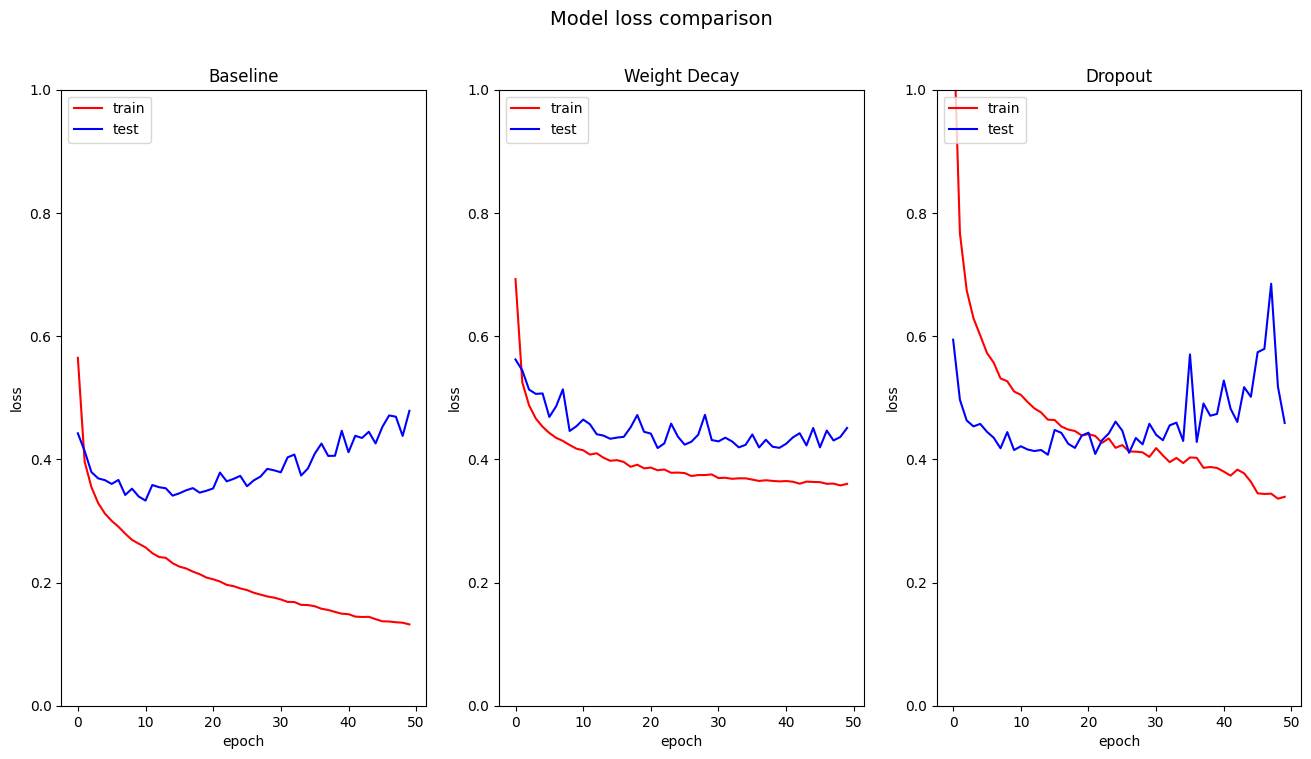

In [11]:
fig=plt.figure(figsize=(16, 8))
for i,h in enumerate(histories):
  plt.subplot(1,3,i+1)
  plt.plot(h.history['loss'],'r')
  plt.plot(h.history['val_loss'],'b')
  plt.ylim((0.,1.))
  plt.title(titles[i])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
plt.suptitle('Model loss comparison', fontsize=14)
plt.show()

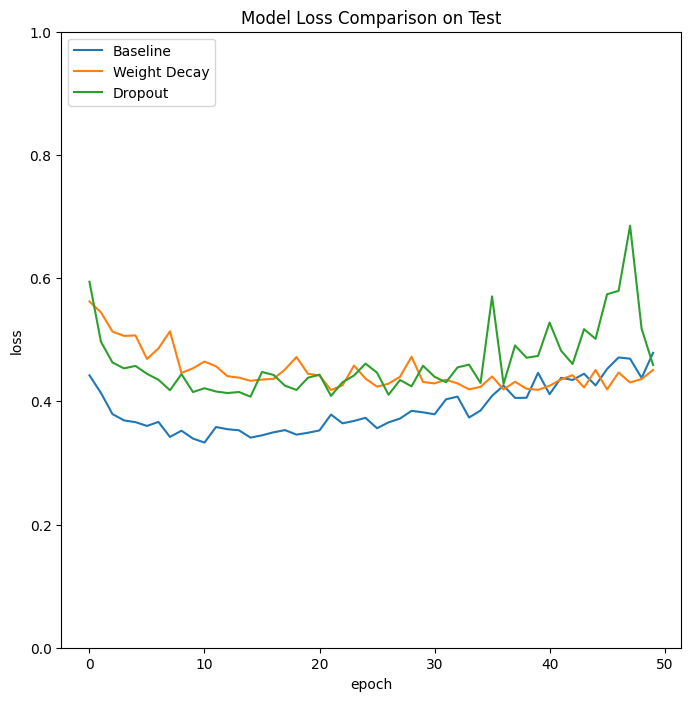

In [12]:
fig=plt.figure(figsize=(8, 8))
for h in histories:
  plt.plot(h.history['val_loss'])
  plt.ylim((0.,1.))
  plt.title('Model Loss Comparison on Test')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()

### Accuracy comparison

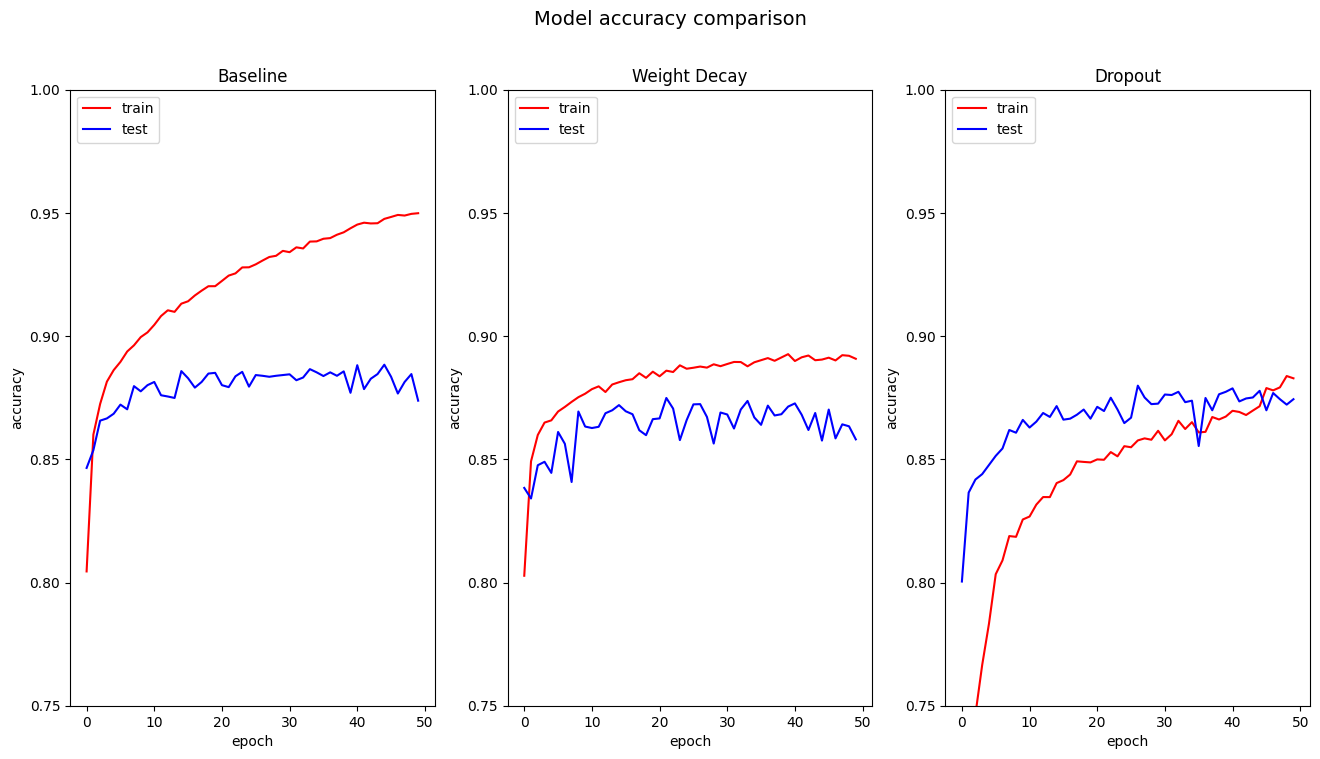

In [13]:
fig=plt.figure(figsize=(16, 8))
for i,h in enumerate(histories):
  plt.subplot(1,3,i+1)
  plt.plot(h.history['accuracy'],'r')
  plt.plot(h.history['val_accuracy'],'b')
  if dataset_name == 'MNIST':
    plt.ylim((0.9,1.))
  else:
    plt.ylim((0.75,1.))
  plt.title(titles[i])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
plt.suptitle('Model accuracy comparison', fontsize=14)
plt.show()

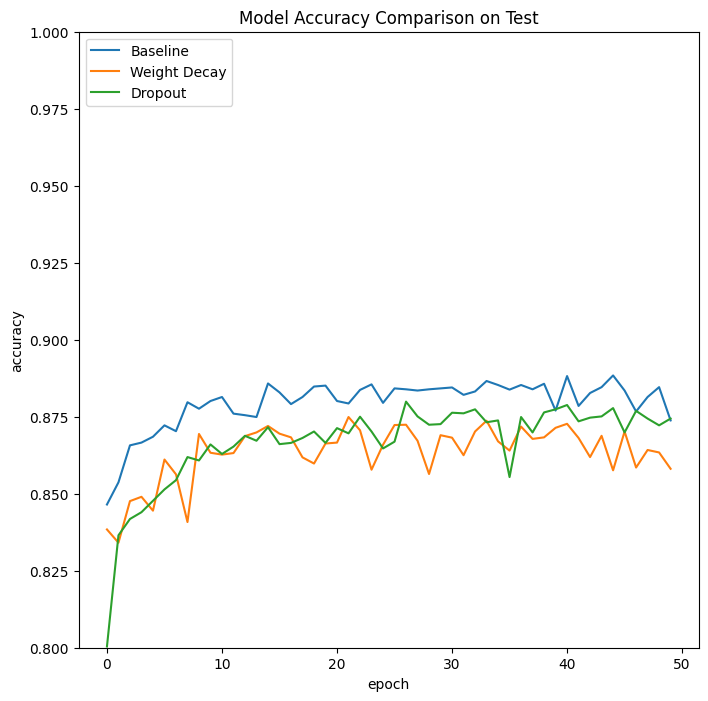

In [14]:
fig=plt.figure(figsize=(8, 8))
for h in histories:
  plt.plot(h.history['val_accuracy'])
  if dataset_name == 'MNIST':
    plt.ylim((0.9,1.))
  else:  
    plt.ylim((0.8,1.))
  plt.title('Model Accuracy Comparison on Test')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(titles, loc='upper left')
plt.show()

## Predict on test set

Use test set for prediction.

In [15]:
model = models[0]
y_pred_sm = model.predict(X_test)
y_pred = np.argmax(y_pred_sm, axis=1)

313/313 [==============================] - 0s 1ms/step


## Evaluate the Model

Evaluation of a specific solution.

### Accuracy

In [17]:
acc = model.evaluate(X_test, y_test)
# acc[0] = Loss
# acc[1] = Accuracy
print("Accuracy %.3f" %acc[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.4787 - accuracy: 0.8738
Accuracy 0.874


### Precision & Recall

In [18]:
print(classification_report(y_test, y_pred, labels=None, digits=3))

              precision    recall  f1-score   support

           0      0.881     0.733     0.800      1000
           1      0.993     0.967     0.980      1000
           2      0.796     0.786     0.791      1000
           3      0.875     0.886     0.881      1000
           4      0.798     0.784     0.791      1000
           5      0.979     0.953     0.966      1000
           6      0.620     0.762     0.684      1000
           7      0.921     0.973     0.946      1000
           8      0.973     0.955     0.964      1000
           9      0.966     0.939     0.952      1000

    accuracy                          0.874     10000
   macro avg      0.880     0.874     0.875     10000
weighted avg      0.880     0.874     0.875     10000



### Confusion Matrix

[[733   0  24  32   6   0 195   1   9   0]
 [  1 967   1  24   4   0   3   0   0   0]
 [  8   0 786  11  79   0 114   0   2   0]
 [ 13   5  16 886  45   0  31   0   4   0]
 [  0   1  82  24 784   0 108   0   1   0]
 [  0   0   0   2   0 953   0  24   1  20]
 [ 72   0  74  27  57   0 762   0   8   0]
 [  0   0   0   0   0  13   0 973   1  13]
 [  5   1   5   6   7   3  15   3 955   0]
 [  0   0   0   0   0   4   1  56   0 939]]


<AxesSubplot: title={'center': 'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

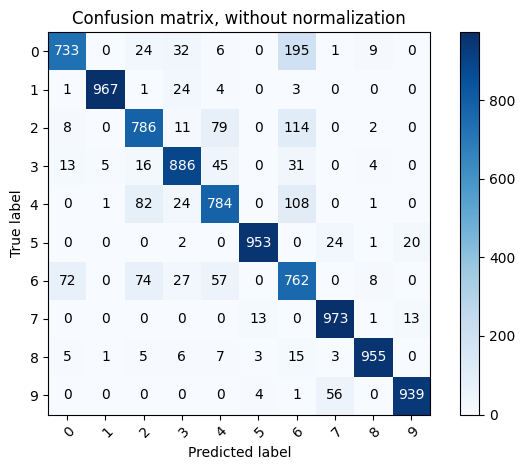

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=False)

# Home Exercises

**Question 1**

Try two more configurations for regulation and compare them with the best result obtained in the above tests.

In [25]:
# Model with regularization
model_1 = keras.models.Sequential([
  keras.layers.Flatten(input_shape=(28, 28)), # We flatten the 28x28 image into a single vector [1, 784]
  
  keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.005)),
  keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.005)),
  keras.layers.Dense(len(class_names), activation='softmax')
])
titles.append("Weight Decay: 0.005")
Wsave = model_1.get_weights() # save the initialized weights 
model_1.set_weights(Wsave) # use the same initialized weights
print(model_1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                50240     
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
newHistory = []
model_1.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

newHistory.append(model_1.fit(X_train, y_train, batch_size=batch_size, epochs=nepochs, validation_data=(X_test,y_test)))

acc = model_1.evaluate(X_test, y_test)
# acc[0] = Loss
# acc[1] = Accuracy
print("Accuracy %.3f" %acc[1])

Epoch 1/50
938/938 [==============================] - 3s 2ms/step - loss: 0.9372 - accuracy: 0.7921 - val_loss: 0.7146 - val_accuracy: 0.8241
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 0.6632 - accuracy: 0.8314 - val_loss: 0.6379 - val_accuracy: 0.8328
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.6171 - accuracy: 0.8365 - val_loss: 0.6335 - val_accuracy: 0.8265
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.5910 - accuracy: 0.8397 - val_loss: 0.6038 - val_accuracy: 0.8265
Epoch 5/50
938/938 [==============================] - 1s 2ms/step - loss: 0.5695 - accuracy: 0.8429 - val_loss: 0.5899 - val_accuracy: 0.8353
Epoch 6/50
938/938 [==============================] - 1s 2ms/step - loss: 0.5580 - accuracy: 0.8449 - val_loss: 0.5811 - val_accuracy: 0.8318
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.5450 - accuracy: 0.8479 - val_loss: 0.5778 - val_accuracy: 0.8338
Epoch 

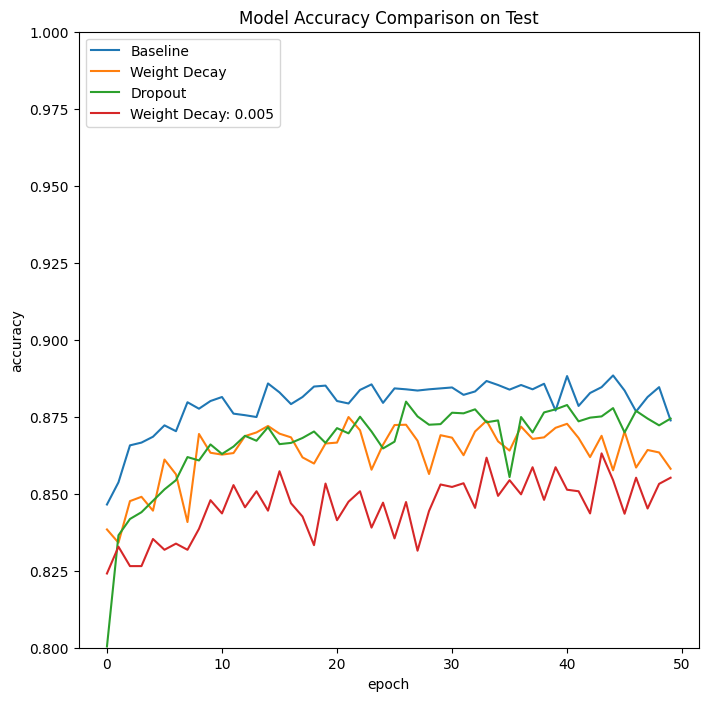

In [28]:
def plot(modelH):
    plt.plot(modelH.history['val_accuracy'])
  
fig = plt.figure(figsize=(8, 8))

for h in histories:
  plot(h)
plot(newHistory[0])

if dataset_name == 'MNIST':
  plt.ylim((0.9,1.))
else:  
  plt.ylim((0.8,1.))
plt.title('Model Accuracy Comparison on Test')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(titles, loc='upper left')
plt.show()